In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats

from sklearn import metrics
from sklearn import model_selection

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint


/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [3]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
import p9_util_benchmark

dict_param_benchmark = p9_util_benchmark.dict_param_benchmark.copy()
#dict_param_benchmark['n_sample'] = 100000
dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': None,
 'n_sample_train': None,
 'is_dataset_reloaded': True,
 'model_type': 'submission',
 'is_model_reloaded': True,
 'threshold': 0.5,
 'embeddings_dimension': 300,
 'val_score_max': True,
 'epochs': 10}

In [5]:
import p9_util_spacy
import p9_util_benchmark
#EMBEDDINGS_PATH = '../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
EMBEDDINGS_PATH = './data/Glove/glove.6B.100d.txt'
#EMBEDDINGS_DIMENSION = 100
EMBEDDINGS_DIMENSION = 300

DROPOUT_RATE = 0.4
LEARNING_RATE = 0.00005
#LEARNING_RATE = 0.0001
NUM_EPOCHS = dict_param_benchmark['epochs']
BATCH_SIZE = 128

MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
#MAX_SEQUENCE_LENGTH = 40

THRESHOLD = dict_param_benchmark['threshold']
THRESHOLD = 0.5
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
is_batch_norm = False

# Convert taget and identity columns to booleans

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= THRESHOLD, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)


def build_embeddings_matrix(tokenizer, dict_param_benchmark) :
    
    filename_embedding_matrix \
    = p9_util_benchmark.build_filename_embedding_matrix(dict_param_benchmark=dict_param_benchmark)

    
    if 'benchmark' == dict_param_benchmark['model_type']:
        embeddings_path = EMBEDDINGS_PATH
    else :
        embeddings_path = None
        
    
    
    is_dataset_reloaded = dict_param_benchmark['is_dataset_reloaded']
    if not is_dataset_reloaded :
        embeddings_index = {}
        # Load embeddings
        if embeddings_path is not None :
            print('\nLoading embeddings...')
            with open(embeddings_path) as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
        else :
            # No path to access embeddings.
            # Embeddings will be retrieved from Spacy package.
            pass
        
        print('\nBuilding embeddings matrix...')
        embeddings_dimension = dict_param_benchmark['embeddings_dimension']
        embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                     embeddings_dimension))
        num_words_in_embedding = 0
        for word, i in tokenizer.word_index.items():
            if 0 < len(embeddings_index) :
                embedding_vector = embeddings_index.get(word)
            else :
                embedding_vector = p9_util_spacy.SPACY_LANGUAGE_MODEL(word).vector

            if embedding_vector is not None:
                num_words_in_embedding += 1
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
                if 0 == i%10000 :
                    print("\nVectorized tokens= {} / {}".format(i, len(tokenizer.word_index)))
                else :
                    pass
            else :
                # Vector for this word does not exists; it is skipped.
                pass
        p5_util.object_dump(embedding_matrix, filename_embedding_matrix, is_verbose=True)
    else : 
        print('\nLoading embeddings matrix...')
        embedding_matrix = p5_util.object_load(filename_embedding_matrix)
    
    return embedding_matrix
    
def build_model(train_df, validate_df, tokenizer, embedding_matrix, dict_param_benchmark=None) :
    
    if dict_param_benchmark is None :
        dict_param_benchmark = p9_util_benchmark.dict_param_benchmark.copy()
    else :
        pass

    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])
    if dict_param_benchmark is None :
        is_dataset_reloaded = False 
    else :
        is_dataset_reloaded = dict_param_benchmark['is_dataset_reloaded']
    
        
        
    # Create model layers.
    def get_convolutional_neural_net_layers(dict_param_benchmark):
        """Returns (input_layer, output_layer)"""
        if dict_param_benchmark is None :
            model_type = 'submission'
        else : 
            model_type = dict_param_benchmark['model_type']

        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embeddings_dimension = dict_param_benchmark['embeddings_dimension']
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    embeddings_dimension,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        
        if 'submission' ==  model_type :
            if is_batch_norm :
                x = BatchNormalization()(x)
            x = Conv1D(256, 2, activation='relu', padding='same')(x)
            x = MaxPooling1D(5, padding='same')(x)

            if is_batch_norm :
                x = BatchNormalization()(x)
            x = Conv1D(256, 3, activation='relu', padding='same')(x)
            x = MaxPooling1D(5, padding='same')(x)
            
            if is_batch_norm :
                x = BatchNormalization()(x)
            x = Conv1D(256, 4, activation='relu', padding='same')(x)
            x = MaxPooling1D(2, padding='same')(x)
            if False :
                if is_batch_norm :
                    x = BatchNormalization()(x)
                x = Conv1D(256, 5, activation='relu', padding='same')(x)
                x = MaxPooling1D(2, padding='same')(x)

                if is_batch_norm :
                    x = BatchNormalization()(x)
                x = Conv1D(256, 6, strides=1, activation='relu', padding='same')(x)
                x = MaxPooling1D(2, padding='same')(x)
            
            x = Flatten()(x)
            if is_batch_norm :
                x = BatchNormalization()(x)
            x = Dropout(DROPOUT_RATE)(x)
            x = Dense(128, activation='relu')(x)
            preds = Dense(2, activation='softmax')(x)
        elif 'benchmark' == model_type :
            x = Conv1D(128, 2, activation='relu', padding='same')(x)
            x = MaxPooling1D(5, padding='same')(x)
            
            x = Conv1D(128, 3, activation='relu', padding='same')(x)
            x = MaxPooling1D(5, padding='same')(x)
            
            x = Conv1D(128, 4, activation='relu', padding='same')(x)
            x = MaxPooling1D(40, padding='same')(x)
            
            x = Flatten()(x)
            x = Dropout(DROPOUT_RATE)(x)
            x = Dense(128, activation='relu')(x)
            preds = Dense(2, activation='softmax')(x)
        else :
            print("\n*** ERROR : Unknown model type = {}".format(dict_param_benchmark['model_type']))
            return None, None
            
        return sequence_input, preds

    
    
    
    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers(dict_param_benchmark)
    if (input_layer is not None) and (output_layer is not None) :
        model = Model(input_layer, output_layer)
        model.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=LEARNING_RATE),
                      metrics=['acc'])
        
        model.summary()
        if dict_param_benchmark['val_score_max'] :
            # checkpoint
            filepath=p9_util_benchmark.build_filename_model(dict_param_benchmark=dict_param_benchmark)
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
            list_callback = [checkpoint]
        else :
            list_callback = None
        return train_text, train_labels, validate_text, validate_labels, model, list_callback
    else :
        print("\n***ERROR : convolutional model building FAILD!")
        return None, None, None, None, None
def train_model(train_text, train_labels, validate_text, validate_labels, model,list_callback=None):
    # Train model.
    val_acc_max = 0.0
    print('\nTraining model...')
    
    history = model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              callbacks=list_callback,
              verbose=1)

    return model, history

#### Build file names for model artefacts.

In [7]:
import pandas as pd
import numpy as np
import keras

import p5_util
import p9_util_benchmark

#filename = './data/benchmark/model_jigsaw_benchmark.h5'

#--------------------------------------------------------------------
# Get configuration for train and validation dataset size.
#--------------------------------------------------------------------
n_sample = dict_param_benchmark['n_sample']
n_sample_train = dict_param_benchmark['n_sample_train']

#--------------------------------------------------------------------
# Build filename for validatation dataset
#--------------------------------------------------------------------
filename_benchmark = p9_util_benchmark.build_filename_benchmark(dict_param_benchmark=dict_param_benchmark)
print("\nFile name for validation dataset = {}".format(filename_benchmark))

#--------------------------------------------------------------------
# Build filename for train dataset
#--------------------------------------------------------------------
filename_benchmark_train = p9_util_benchmark.build_filename_benchmark(dict_param_benchmark=dict_param_benchmark, is_train=True)
print("\nFile name for train dataset = {}".format(filename_benchmark_train))

#--------------------------------------------------------------------
# Build filename for benchmark model
#--------------------------------------------------------------------
filename_model = p9_util_benchmark.build_filename_model(dict_param_benchmark=dict_param_benchmark)
print("\nFile name for model = {}".format(filename_model))


#--------------------------------------------------------------------
# Build filename for Tokenizer
#--------------------------------------------------------------------
filename_tokenizer = p9_util_benchmark.build_filename_tokenizer(dict_param_benchmark=dict_param_benchmark)
print("\nFile name for tokenizer = {}".format(filename_tokenizer))

#--------------------------------------------------------------------
# Build filename for matrix of embeddings
#--------------------------------------------------------------------
filename_embedding = p9_util_benchmark.build_filename_embedding_matrix(dict_param_benchmark=dict_param_benchmark)
print("\nFile name for embeddings matrix = {}".format(filename_embedding))


File name for validation dataset = ./data/benchmark/df_sample_benchmark_valid_300D_FULL.dill

File name for train dataset = ./data/benchmark/df_sample_benchmark_train_300D_FULL.dill

File name for model = ./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5

File name for tokenizer = ./data/benchmark/tokenizer_FULL.dill

File name for embeddings matrix = ./data/benchmark/embedding_matrix_300D_FULL.dill


#### Reload dataset / build dataset along with tokenizer and embeddings matrix

##### Load configuration file previoulsy used for building dataset, tokenizer and embeddings matrix

    Then update flag is_dataset_reload.

In [8]:
import p5_util
if dict_param_benchmark['is_dataset_reloaded'] :
    df_train         = p5_util.object_load(filename_benchmark_train, is_verbose = True) 
    df_validate      = p5_util.object_load(filename_benchmark, is_verbose = True) 
    tokenizer        = p5_util.object_load(filename_tokenizer, is_verbose = True) 
    embedding_matrix = p5_util.object_load(filename_embedding, is_verbose = True) 
else :
    #------------------------------------------------------------
    # Build and train benchmark model issued from Kaggle kernel
    # benchmark.
    #------------------------------------------------------------
    print("\nLoad dataset...")
    df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
    df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())
    df_train['comment_text'] = df_train['comment_text'].astype(str)
    

    n_sample_train = p9_util_benchmark.dict_param_benchmark['n_sample_train']
    if n_sample_train is None :
        print("\nBenchmark model is trained with ALL comments from train dataset")
    else :
        df_train = df_train.sample(n_sample_train)
        print("\nBenchmark model is trained with {} comments from train dataset".format(n_sample_train))

    #------------------------------------------------------------
    # Convert model for binay classification
    #------------------------------------------------------------
    df_train = convert_dataframe_to_bool(df_train)

    #------------------------------------------------------------
    # Split dataset as train and validation dataset.
    #------------------------------------------------------------
    df_train, df_validate = model_selection.train_test_split(df_train, test_size=0.2)
    print('%d train comments, %d validate comments' % (len(df_train), len(df_validate)))

    #------------------------------------------------------------
    # Update validation samples count.
    #------------------------------------------------------------
    n_sample = len(df_validate)
    dict_param_benchmark['n_sample'] = n_sample   
    
    
    
    #------------------------------------------------------------
    # Build Tokenizer
    #------------------------------------------------------------
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(df_train[TEXT_COLUMN])
        
    #------------------------------------------------------------
    # Build embedding matrix
    #------------------------------------------------------------
    embedding_matrix = build_embeddings_matrix(tokenizer, dict_param_benchmark)    

    #--------------------------------------------------------------------
    # Save embedding matrix
    #--------------------------------------------------------------------
    filename_embedding = p9_util_benchmark.build_filename_embedding_matrix(dict_param_benchmark=dict_param_benchmark)
    p5_util.object_dump(embedding_matrix,filename_embedding, is_verbose=True )
    

    #--------------------------------------------------------------------
    # Save train dataset
    #--------------------------------------------------------------------
    filename_benchmark_train = p9_util_benchmark.build_filename_benchmark(dict_param_benchmark=dict_param_benchmark, is_train=True)
    p5_util.object_dump(df_train,filename_benchmark_train, is_verbose=True )
    
    #------------------------------------------------------------
    # Save validation dataset; this validation dataset will be 
    # used by submition model in order to compare both models 
    # performances.
    #------------------------------------------------------------
    filename_benchmark = p9_util_benchmark.build_filename_benchmark(dict_param_benchmark=dict_param_benchmark)
    p5_util.object_dump(df_validate.sample(n_sample),filename_benchmark, is_verbose=True )

    
    #------------------------------------------------------------
    # Save tokenizer
    #------------------------------------------------------------
    filename_tokenizer = p9_util_benchmark.build_filename_tokenizer(dict_param_benchmark=dict_param_benchmark)
    p5_util.object_dump(tokenizer,filename_tokenizer, is_verbose=True)
    
    #------------------------------------------------------------
    # Save configuration
    # When going to this sequences, then is_dataset_reloaded flag
    # is fixed to True.
    # This allows to use parameters in a mode where dataset  is 
    # reloaded rather then rebuilt.
    #------------------------------------------------------------
    dict_param_benchmark['is_dataset_reloaded'] = True
    filename_param = p9_util_benchmark.build_filename_param(dict_param_benchmark=dict_param_benchmark)
    p5_util.object_dump(dict_param_benchmark,filename_param, is_verbose=True)
        

p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_train_300D_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_valid_300D_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/tokenizer_FULL.dill
p5_util.object_load : fileName= ./data/benchmark/embedding_matrix_300D_FULL.dill


In [10]:
embedding_matrix.shape

(352897, 300)

#### Build CNN model

In [8]:
dict_param_benchmark

{'root_directory': './data/benchmark/',
 'format_file': '.dill',
 'format_model': '.h5',
 'root_filename_benchmark': './data/benchmark/df_sample_benchmark_',
 'root_filename_model': 'model_jigsaw_',
 'n_sample': None,
 'n_sample_train': None,
 'is_dataset_reloaded': True,
 'model_type': 'submission',
 'is_model_reloaded': True,
 'threshold': 0.5,
 'embeddings_dimension': 300,
 'val_score_max': True,
 'epochs': 10}

In [10]:
filename_model

'./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5'

In [9]:
if not dict_param_benchmark['is_model_reloaded'] :
    #------------------------------------------------------------
    # Train benchmark model
    #------------------------------------------------------------
    train_text, train_labels, validate_text, validate_labels, model,list_callback =\
    build_model(df_train, df_validate, tokenizer, embedding_matrix, \
                dict_param_benchmark=dict_param_benchmark) 

    #------------------------------------------------------------
    # Save benchmark model
    #------------------------------------------------------------
    if False :
        if model is not None :
            model.save(filename_model)    
        else :
            pass
else :
    #-------------------------------------------------------------
    # Load benchmark model.
    #-------------------------------------------------------------
    print("\nLoading model...")
    model = keras.models.load_model(filename_model)
    model.summary()
    
    

W1014 23:05:58.401522 139914000693056 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 23:05:58.492946 139914000693056 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1014 23:05:58.493691 139914000693056 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1014 23:05:58.520922 139914000693056 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138


Loading model...


W1014 23:05:58.884912 139914000693056 deprecation.py:506] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1014 23:05:59.070229 139914000693056 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1014 23:05:59.508447 139914000693056 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1014 23:05:59.514635 139914000693056 deprecation.py:323] Fro

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 105, 300)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 105, 300)          1200      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 105, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 21, 256)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 256)           196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 256)            0         
__________

In [12]:
import p5_util
model, history = train_model(train_text, train_labels, validate_text, validate_labels, \
                             model,list_callback=list_callback)


Training model...
Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
1443899/1443899 [==============================] - 2708s 2ms/step - loss: 0.1678 - acc: 0.9402 - val_loss: 0.1538 - val_acc: 0.9446

Epoch 00001: val_acc improved from -inf to 0.94462, saving model to ./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5
Epoch 2/10
1443899/1443899 [==============================] - 3222s 2ms/step - loss: 0.1480 - acc: 0.9465 - val_loss: 0.1561 - val_acc: 0.9435

Epoch 00002: val_acc did not improve from 0.94462
Epoch 3/10
1443899/1443899 [==============================] - 2943s 2ms/step - loss: 0.1446 - acc: 0.9478 - val_loss: 0.1436 - val_acc: 0.9477

Epoch 00003: val_acc improved from 0.94462 to 0.94774, saving model to ./data/benchmark/model_jigsaw_submission_sampleFULL_threshold0.5_best.h5
Epoch 4/10
1443899/1443899 [==============================] - 2727s 2ms/step - loss: 0.1415 - acc: 0.9487 - val_loss: 0.1493 - val_acc: 0.9483

Epoch 00004: val_

In [14]:
import keras
import p5_util
import p9_util_benchmark

filename= p9_util_benchmark.build_filename_model(dict_param_benchmark=dict_param_benchmark)
filename = './data/benchmark/model_jigsaw_submission_sample500000_threshold0.5_best.h5'
model = keras.models.load_model(filename)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 300)          53891100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 256)           196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 256)           262400    
__________

In [25]:
df_validate      = p5_util.object_load(filename_benchmark, is_verbose = True) 
df_validate = df_validate.sample(10000)

p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_valid_300D_FULL.dill


In [26]:
import p9_util_metrics

MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_metrics.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
overall_auc = p9_util_metrics.calculate_overall_auc(df_validate, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
print("Overall AUC = {}".format(overall_auc))

score = p9_util_metrics.get_final_metric(df_bias_metrics, overall_auc)
print("Score = {}".format(score))
print("")
df_bias_metrics


Overall AUC = 0.5588822503599625
Bias score contribution : 0.3481265522855502
Score = 0.4878471148755408



,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
4,0.317027,0.539426,jewish,0.323810,41
8,0.470123,0.505038,psychiatric_or_mental_illness,0.365079,24
7,0.422495,0.568346,white,0.430749,153
6,0.420804,0.604092,black,0.470690,78
0,0.569409,0.507599,male,0.520016,235
1,0.576485,0.537766,female,0.553229,299
3,0.623800,0.488001,christian,0.556935,216
5,0.603288,0.517964,muslim,0.559667,117
2,0.526310,0.606838,homosexual_gay_or_lesbian,0.565116,53


In [9]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print("Overall AUC = {}".format(overall_auc))

score = p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)
print("Score = {}".format(score))
print("")
df_bias_metrics


Overall AUC = 0.929906737694202
Bias score contribution : 0.6557258772464325
Score = 0.888202561669983



,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
5,0.947862,0.805555,muslim,0.818181,4261
7,0.958519,0.785189,white,0.821673,5015
6,0.959149,0.779959,black,0.821964,2958
2,0.955701,0.793160,homosexual_gay_or_lesbian,0.826999,2209
4,0.934687,0.862453,jewish,0.854121,1563
8,0.946230,0.845690,psychiatric_or_mental_illness,0.867229,964
1,0.931124,0.885238,female,0.880461,10789
0,0.945799,0.870465,male,0.887908,8823
3,0.911606,0.916216,christian,0.892852,8246


In [ ]:
import p5_util
import p9_util_benchmark

#dict_param_benchmark = p9_util_benchmark.dict_param_benchmark.copy()
dict_param_benchmark
#------------------------------------------------------------
# Save history
#------------------------------------------------------------
filename_history = p9_util_benchmark.build_filename_history(dict_param_benchmark=dict_param_benchmark)
p5_util.object_dump(history, filename_history, is_verbose=True)

In [17]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print("Overall AUC = {}".format(overall_auc))

score = p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)
print("Score = {}".format(score))
print("")
df_bias_metrics


Overall AUC = 0.9235434268035685
Bias score contribution : 0.6504264097286355
Score = 0.8813122664295276



,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.955746,0.741333,black,0.774689,877
2,0.946683,0.774918,homosexual_gay_or_lesbian,0.796854,634
7,0.958981,0.762359,white,0.811306,1377
5,0.948299,0.803654,muslim,0.820926,1190
4,0.943460,0.849810,jewish,0.864738,440
0,0.939573,0.853694,male,0.868016,2399
1,0.945457,0.863649,female,0.888232,2992
3,0.932038,0.903479,christian,0.911376,2212
8,0.968030,0.835439,psychiatric_or_mental_illness,0.913961,254


In [28]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print("Overall AUC = {}".format(overall_auc))

score = p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)
print("Score = {}".format(score))
print("")
df_bias_metrics


Overall AUC = 0.8773481156459169
Bias score contribution : 0.615308740767306
Score = 0.8346457696787852



,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.860107,0.754596,homosexual_gay_or_lesbian,0.732222,61
4,0.818222,0.802380,jewish,0.751323,34
6,0.912800,0.741271,black,0.787715,92
8,0.778932,0.891993,psychiatric_or_mental_illness,0.788235,22
5,0.924140,0.766183,muslim,0.795966,108
1,0.865721,0.839276,female,0.821829,309
0,0.899045,0.812364,male,0.826001,262
7,0.933312,0.746423,white,0.837827,149
3,0.934860,0.858851,christian,0.924326,220


Overall AUC = 0.8773481156459169
Bias score contribution : 0.615308740767306
Score = 0.8346457696787852


#### Predictions over validation dataset

In [77]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
8,0.731569,0.821137,psychiatric_or_mental_illness,0.717647,22
2,0.855819,0.757932,homosexual_gay_or_lesbian,0.733333,61
6,0.866616,0.740886,black,0.739558,92
4,0.888712,0.780131,jewish,0.751323,34
0,0.840319,0.812571,male,0.771372,262
1,0.834556,0.829489,female,0.780331,309
7,0.921840,0.731057,white,0.807296,149
5,0.919802,0.774173,muslim,0.821295,108
3,0.904666,0.867893,christian,0.910186,220


In [78]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print(overall_auc)

p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

0.8674375892460832
Bias score contribution : 0.6012027589900717


0.8180621563015925

In [72]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
6,0.919121,0.729760,black,0.788206,92
2,0.878579,0.804194,homosexual_gay_or_lesbian,0.788889,61
5,0.935725,0.732650,muslim,0.796904,108
7,0.948050,0.701632,white,0.804718,149
1,0.873481,0.833897,female,0.808754,309
0,0.899798,0.807535,male,0.826001,262
8,0.863115,0.909583,psychiatric_or_mental_illness,0.870588,22
4,0.965130,0.730704,jewish,0.873016,34
3,0.938003,0.871664,christian,0.933229,220


In [73]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print(overall_auc)

p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

0.8828159251298147
Bias score contribution : 0.6274428311249021


0.8481468124073557

In [65]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
1,0.703854,0.842689,female,0.716502,309
2,0.781857,0.782033,homosexual_gay_or_lesbian,0.732778,61
5,0.816646,0.756270,muslim,0.736398,108
7,0.824397,0.753858,white,0.743259,149
6,0.811353,0.790321,black,0.761179,92
4,0.781616,0.794209,jewish,0.761905,34
3,0.772935,0.863786,christian,0.808850,220
0,0.831307,0.811742,male,0.810467,262
8,0.796806,0.859626,psychiatric_or_mental_illness,0.823529,22


In [66]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print(overall_auc)

p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

0.82918226667752
Bias score contribution : 0.586736648403426


0.794032215072806

In [56]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
4,0.902744,0.756994,jewish,0.735450,34
6,0.917835,0.714405,black,0.736118,92
2,0.899222,0.769472,homosexual_gay_or_lesbian,0.771111,61
5,0.929789,0.771300,muslim,0.813790,108
7,0.944449,0.743588,white,0.819389,149
0,0.897253,0.821464,male,0.828190,262
1,0.882863,0.845516,female,0.836609,309
8,0.891730,0.873276,psychiatric_or_mental_illness,0.870588,22
3,0.915712,0.872995,christian,0.907567,220


In [57]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print(overall_auc)

p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

0.8866337977537542
Bias score contribution : 0.6239334298311822


0.8455918792696206

In [13]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print(overall_auc)

p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

0.8813846123686974
Bias score contribution : 0.6311989177686654


0.8515450708608397

In [23]:
import p5_util
p5_util.object_dump(history,'./data/benchmark/history_20Epoch_50000.dill')

#### Load validation dataset

In [13]:
import p5_util
df_validate = p5_util.object_load('./data/benchmark/df_sample_benchmark_valid_360975.dill')

p5_util.object_load : fileName= ./data/benchmark/df_sample_benchmark_valid_360975.dill


In [14]:
len(df_validate)

360975

#### Predictions over validation dataset

In [16]:
MODEL_NAME = 'my_model'
df_validate[MODEL_NAME] = model.predict(pad_text(df_validate[TEXT_COLUMN], tokenizer))[:, 1]

import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
0,0.423482,0.527633,male,0.479227,16117
5,0.379671,0.578172,muslim,0.485176,5200
1,0.413221,0.545691,female,0.486553,14774
2,0.420225,0.537800,homosexual_gay_or_lesbian,0.488713,3034
3,0.395996,0.564799,christian,0.488767,12325
7,0.412021,0.552818,white,0.493640,6094
4,0.386923,0.587823,jewish,0.501126,2079
6,0.415539,0.561902,black,0.506197,3961
8,0.441750,0.553171,psychiatric_or_mental_illness,0.523564,2057


In [18]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
print(overall_auc)

p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

Bias score contribution : 0.3640472701244321


0.4814985731733033

In [18]:
import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
4,0.858809,0.622410,jewish,0.710941,229
6,0.899848,0.536487,black,0.712272,415
5,0.893310,0.577209,muslim,0.723871,589
7,0.910689,0.547952,white,0.738688,655
1,0.854539,0.655009,female,0.740394,1623
3,0.814839,0.715750,christian,0.747667,1355
2,0.904465,0.569516,homosexual_gay_or_lesbian,0.752778,306
8,0.822805,0.710397,psychiatric_or_mental_illness,0.755221,221
0,0.853071,0.675013,male,0.764639,1750


In [19]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
overall_auc

0.7831349797714786

In [20]:
p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

Bias score contribution : 0.5512879262998152


0.7470716712426848

In [25]:
import p9_util_benchmark
df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
df_bias_metrics

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
5,0.893172,0.455094,muslim,0.625448,179
2,0.866740,0.568029,homosexual_gay_or_lesbian,0.664032,100
4,0.908445,0.528858,jewish,0.693135,70
7,0.926768,0.482684,white,0.695527,226
1,0.860868,0.610430,female,0.697728,515
3,0.840209,0.650368,christian,0.710166,381
6,0.908605,0.554461,black,0.718285,151
0,0.865677,0.624584,male,0.729710,552
8,0.868687,0.671004,psychiatric_or_mental_illness,0.744697,74


In [26]:
overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate, MODEL_NAME)
overall_auc

0.7869874012801156

In [27]:
p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

Bias score contribution : 0.5291632672606412


0.7259101175806701

### Benchmark model considering number of samples for validation.

In [54]:
MODEL_NAME = 'my_model'
n_sample = 1000
list_i_sample=[i_sample for i_sample in range(n_sample,df_validate.shape[0], n_sample)]
list_i_sample

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]

In [55]:
dict_final_metric = dict()
for i_sample in list_i_sample:
    print(0,i_sample, end='\r')

    df_validate_sample = df_validate.iloc[0:i_sample]
    df_validate_sample[MODEL_NAME] = \
    model.predict(pad_text(df_validate_sample[TEXT_COLUMN], tokenizer))[:, 1]

    df_bias_metrics = p9_util_benchmark.compute_bias_metrics_for_model(df_validate_sample, identity_columns, MODEL_NAME, TOXICITY_COLUMN)

    overall_auc = p9_util_benchmark.calculate_overall_auc(df_validate_sample, MODEL_NAME)

    dict_final_metric[i_sample] = p9_util_benchmark.get_final_metric(df_bias_metrics, overall_auc)

Bias score contribution : 0.5146468627064191
Bias score contribution : 0.5311479703229279
Bias score contribution : 0.5531618796000058
Bias score contribution : 0.5341103982806941
Bias score contribution : 0.5352761914396593
Bias score contribution : 0.540778956436581
Bias score contribution : 0.5518264065450231
Bias score contribution : 0.549252664069153
Bias score contribution : 0.5451565086022001
Bias score contribution : 0.5492753276817949
Bias score contribution : 0.5490391185560244


In [60]:
ser_final_metric = pd.Series(dict_final_metric)
ser_final_metric

1000     0.716296
2000     0.731172
3000     0.751949
4000     0.732136
5000     0.731803
6000     0.737424
7000     0.748801
8000     0.745725
9000     0.741739
10000    0.746510
11000    0.746110
dtype: float64

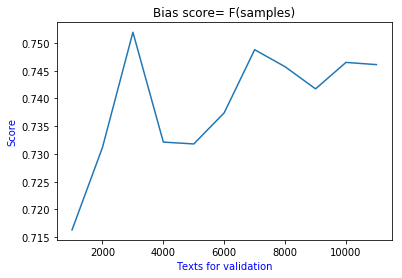

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'
ax = plt.gca()

ser_final_metric.plot(kind='line',ax=ax, title="Bias score= F(samples)", x='samples')
#ser_final_metric.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)
ax.set_xlabel('Texts for validation', color='b')
ax.set_ylabel('Score', color='b')
plt.show()

### Submission

#### Load model

In [1]:
import keras
import p5_util
filename_model = './data/benchmark/model_jigsaw_benchmark_sampleFULL_threshold0.1.h5'
model = keras.models.load_model(filename_model)

filename_tokenizer = './data/benchmark/tokenizer_FULL.dill'
tokenizer = p5_util.object_load(filename_tokenizer)

Using TensorFlow backend.
W1008 10:22:58.903397 140393805576000 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 10:22:58.990973 140393805576000 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1008 10:22:59.023194 140393805576000 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1008 10:22:59.188047 140393805576000 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_defau

p5_util.object_load : fileName= ./data/benchmark/tokenizer_FULL.dill


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 300)          105909900 
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 256)          230656    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 25, 256)           262400    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3, 256)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 256)            327936    
__________

In [7]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

if True :
    df_test = pd.read_csv('./data/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
    submission = pd.read_csv('./sample_submission.csv', index_col='id')

    submission['prediction'] = model.predict(pad_text(df_test[TEXT_COLUMN], tokenizer))[:, 1]

In [10]:
submission.to_csv('./data/benchmark/submission.csv')